# Navigation

In this part of the tutorial, we'll learn how to create and navigate between multiple lists of pages called *branches*.

Navigate functions are useful for things like adaptive testing: when we ask users harder questions if and only if they get easier questions correct first.

Run the cell below to create a test app.

In [12]:
import os

from hemlock import User, Page, create_test_app
from hemlock.questions import Input, Label
from sqlalchemy_mutable.utils import partial
import random

os.environ.pop("GITPOD_HOST", None)

app = create_test_app()

We can add a navigate function to a page by passing `navigate=some_navigate_function`. The navigate function take its "parent" page as its argument and returns a list of pages. After the page with the navigate function, the user is redirected to the branch returned by the navigate function.

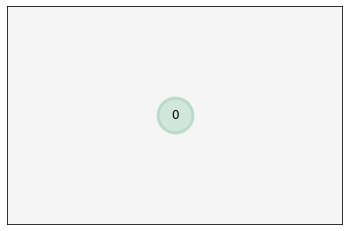

In [2]:
def seed():
    return [
        Page(
            Input("Hello, world!"),
            navigate=make_next_branch
        )
    ]


def make_next_branch(page):
    return [
        Page(
            Label("Goodbye, world!")
        )
    ]


user = User.make_test_user(seed)
user.test_get().display()

INFO:root:<Page 0>
    <Input Hello, world! - default: None>
        test response: 'z56PiR3K9 NJThrBPET'
    test direction: 'forward'


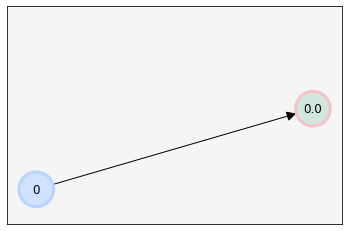

In [3]:
user.test_request().display()

In this figure, we can see how compile, validate, submit, and navigate functions work together in the "page logic."

<img src="../static/page_logic.png" style="background-color:white;width=100%">

We can also get a sense of the page logic by running the cell below. When the user submits the 0th page, the following things happen:

0. The 0th page's validate functions are called.
1. If the responses are valid, the 0th page's submit functions are called.
2. The user is redirected to the branch returned by the 0th page's navigate function
3. The next page's compile functions are called.
4. The user sees the next page.

INFO:root:<Page 0>
    <Input Hello, world! - default: None>
        test response: '0'
    test direction: 'forward'


validate_func was called with parent <Input Hello, world! - response: '0'>.
submit_func was called with parent <Input Hello, world! - response: '0'>.
navigate func was called with parent <Page 0>
    <Input Hello, world! - response: '0'>.
compile_func was called with parent <Label Goodbye, world! - default: None>.


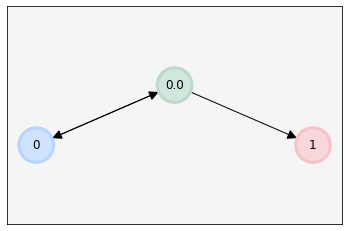

INFO:root:<Page 0.0>
    <Label Goodbye, world! - default: None>
        test response: None
    test direction: 'back'


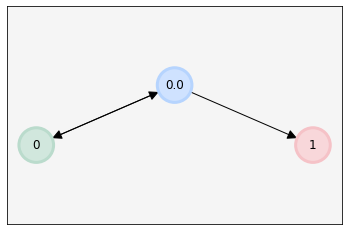

INFO:root:<Page 0>
    <Input Hello, world! - response: '0'>
        test response: '1'
    test direction: 'forward'


validate_func was called with parent <Input Hello, world! - response: '1'>.
submit_func was called with parent <Input Hello, world! - response: '1'>.
navigate func was called with parent <Page 0>
    <Input Hello, world! - response: '1'>.
compile_func was called with parent <Label 1 Goodbye, world! - default: None>.


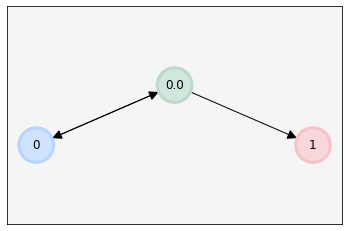

In [2]:
def seed():
    return [
        Page(
            thingy := Input(
                "Hello, world!",
                validate=validate_func,
                submit=submit_func
            ),
            navigate = partial(navigate_func,thingy)
        ),
        Page(
            Label('goobye')
        )
    ]


def validate_func(parent):
    print(f"validate_func was called with parent {parent}.")


def submit_func(parent):
    print(f"submit_func was called with parent {parent}.")


def navigate_func(parent,thingy):
    print(f"navigate func was called with parent {parent}.")
    if thingy.response == '0':
        return [
            Page(
                Label("Goodbye, world!", compile=compile_func),
                back = True
            )
        ]
    return [
        Page(
            Label(f"{thingy.response} Goodbye, world!", compile=compile_func),
            back = True
        )]


def compile_func(parent):
    print(f"compile_func was called with parent {parent}.")


user = User.make_test_user(seed)
user.test_request(['0']).display()
user.test_request(direction="back").display()
user.test_request(['1']).display()

The cell below defines a basic adaptive test. It shows the user a hard and really hard question if and only if the user gets an easy question correct first.

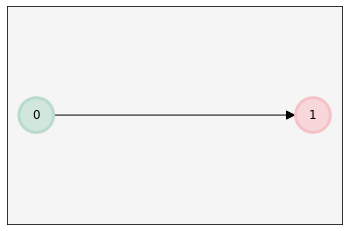

In [4]:
EASY_ANSWER = "42"
HARD_ANSWER = "88"
REALLY_HARD_ANSWER = "76"

def seed():
    return [
        Page(
            Input(f"The correct answer to this easy question is '{EASY_ANSWER}'."),
            navigate=make_hard_branch
        ),
        Page(
            Label("Goodbye!")
        )
    ]


def make_hard_branch(page):
    # ask the harder questions if and only if the user got the easy question correct
    if page.questions[0].response != EASY_ANSWER:
        return []

    return [
        Page(
            Input(f"The correct answer to this hard question is '{HARD_ANSWER}'."),
        ),
        Page(
            Input(f"The answer to this really hard question is '{REALLY_HARD_ANSWER}'.")
        )
    ]


user = User.make_test_user(seed)
user.test_get().display()

Look at the navigation tree above. Now, in the cell below, notice how the "navigation tree" changes when the user answers the easy question correctly. The 0th page now has pages 0.0 and 0.1 "branching" off of it. After page 0.1, the user goes to page 1.

The green circle means that the user is currently on that page. The red circle is where the survey ends.

INFO:root:<Page 0>
    <Input The correct answer to this easy [...] - default: None>
        test response: '42'
    test direction: 'forward'


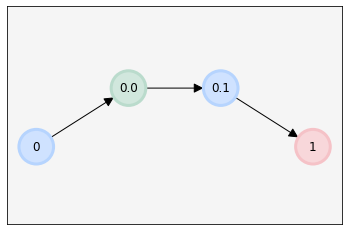

In [5]:
user.test_request([EASY_ANSWER]).display()

INFO:root:<Page 0.0>
    <Input The correct answer to this hard [...] - default: None>
        test response: 's k z dx'
    test direction: 'forward'


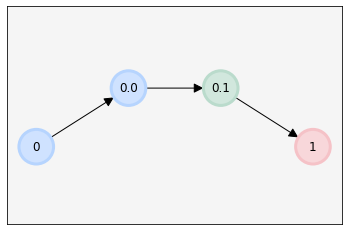

In [6]:
user.test_request().display()

INFO:root:<Page 0.1>
    <Input The answer to this really hard [...] - default: None>
        test response: 'NTNPoiC'
    test direction: 'forward'


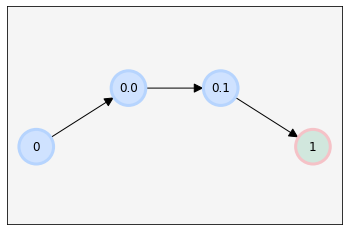

In [7]:
user.test_request().display()

Now see what happens when the user answer the easy question incorrectly.

INFO:root:<Page 0>
    <Input The correct answer to this easy [...] - default: None>
        test response: 'INCORRECT_ANSWER'
    test direction: 'forward'


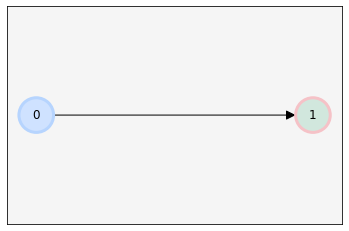

In [8]:
user = User.make_test_user(seed)
user.test_request(["INCORRECT_ANSWER"]).display()

## Exercises

0. Modify the adaptive test survey above so that the user gets the really hard question if and only if they answer the hard question correctly.
1. Make a test user go through the survey and see what happens when:

    0. You answer the easy and hard questions correctly.
    1. You answer the easy question correctly but the hard question incorrectly.
    2. You answer the easy question incorrectly.
2. Transfer the survey you wrote in step 0 to `src/my_survey.py`, run the app, and verify that it's working as expected.
3. Test your code with `make test`. To fully cover your code, make sure some of your users get the easy question right (and others get it wrong) and make sure some of your users get the hard question right (and others get it wrong).

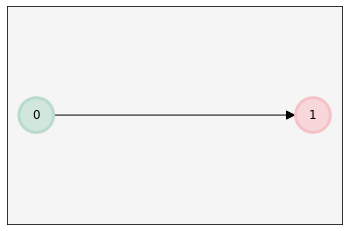

INFO:root:<Page 0>
    <Input The correct answer to this easy [...] - default: None>
        test response: '42'
    test direction: 'forward'


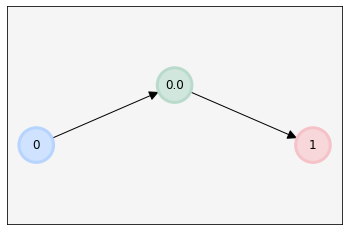

INFO:root:<Page 0.0>
    <Input The correct answer to this hard [...] - default: None>
        test response: '88'
    test direction: 'forward'


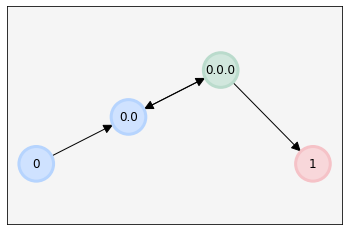

INFO:root:<Page 0.0.0>
    <Input The answer to this really hard [...] - default: None>
        test response: 'bEr0fNtkaryjQRha'
    test direction: 'back'


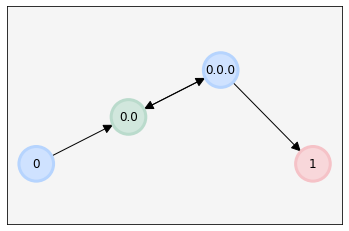

INFO:root:<Page 0.0>
    <Input The correct answer to this hard [...] - response: '88'>
        test response: 'HARD_ANSWER'
    test direction: 'forward'


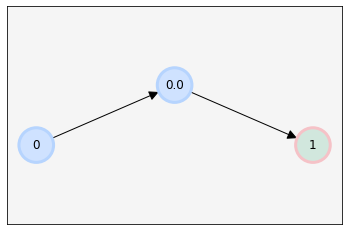

In [11]:
# WRITE YOUR CODE HERE

EASY_ANSWER = "42"
HARD_ANSWER = "88"
REALLY_HARD_ANSWER = "76"

def seed():
    return [
        Page(
            Input(f"The correct answer to this easy question is '{EASY_ANSWER}'."),
            navigate=make_hard_branch,
            test_response=EASY_ANSWER
        ),
        Page(
            Label("Goodbye!")
        )
    ]


def make_hard_branch(page):
    # ask the harder questions if and only if the user got the easy question correct
    if page.questions[0].response != EASY_ANSWER:
        return []

    return [
        Page(
            Input(f"The correct answer to this hard question is '{HARD_ANSWER}'."),
            navigate = make_really_hard_branch,
            test_response=random.choice([EASY_ANSWER,HARD_ANSWER])
        ),
        
    ]

def make_really_hard_branch(page):
    if page.questions[0].response != HARD_ANSWER:
        return []
    
    return [
        Page(
            Input(f"The answer to this really hard question is '{REALLY_HARD_ANSWER}'."),
            back=True
        )]


user = User.make_test_user(seed)
user.test_get().display()
user.test_request([EASY_ANSWER]).display()
user.test_request([HARD_ANSWER]).display()
user.test_request(direction="back").display()
user.test_request(['HARD_ANSWER']).display()


## Answers

In [ ]:
EASY_ANSWER = "42"
HARD_ANSWER = "88"
REALLY_HARD_ANSWER = "76"

def seed():
    return [
        Page(
            Input(f"The correct answer to this easy question is '{EASY_ANSWER}'."),
            navigate=make_hard_branch
        ),
        Page(
            Label("Goodbye!")
        )
    ]


def make_hard_branch(page):
    # ask the harder questions if and only if the user got the easy question correct
    if page.questions[0].response != EASY_ANSWER:
        return []

    return [
        Page(
            Input(f"The correct answer to this hard question is '{HARD_ANSWER}'."),
            navigate=make_really_hard_branch
        )
    ]


def make_really_hard_branch(page):
    if page.questions[0].response != HARD_ANSWER:
        return []

    return [
        Page(
            Input(f"The answer to this really hard question is '{REALLY_HARD_ANSWER}'.")
        )
    ]


user = User.make_test_user(seed)
user.test_get().display()

In [ ]:
user.test_request([EASY_ANSWER]).display()

In [ ]:
user.test_request([HARD_ANSWER]).display()

In [ ]:
user.test_request([REALLY_HARD_ANSWER]).display()

In [ ]:
user = User.make_test_user(seed)
user.test_request([EASY_ANSWER]).display()

In [ ]:
user.test_request(["INCORRECT_ANSWER"]).display()

In [ ]:
user = User.make_test_user(seed)
user.test_request(["INCORRECT_ANSWER"]).display()

See `src/navigate.py` for what your survey file should look like.

Now you know how to use navigate functions! Check out `100_utils.ipynb` for the next part of the tutorial.